# 320to335 (15-30 November)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Nov15-30woP.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_AGS_320to335']
X0 = df.loc[:, ~df.columns.isin(['std_inz_AGS_320to335'])]
f_names = list(X0.columns)
print("Number of features: ", len(X0.columns))

Number of features:  147


# drop high correlated features

In [4]:
a=['D_v599', 'HC_aerztever', 'HC_Pflegehe', 'HC_Vorzeitig', 'INC_Bruttow', 'INC_Schuldn', 'INC_v793', 'IS_endlersaldo2017', 'IS_v1069', 'IS_v1070', 'IS_v1071', 'IS_v1073', 'PRE_v698', 'PRE_v727', 'PRE_v733', 'PRE_v739', 'SSE_AnteilErh', 'SSE_AnteilFre', 'SSE_AnteilWas', 'SSE_Einwohner', 'SSE_Siedlungs', 'SSE_v967', 'Std_j00j99krankhe', 'UE_AnteBesch', 'UE_ArbquoteJ', 'UE_v305', 'UE_v381']
print(set(a),"\n\n",len(set(a)),"features droped")

{'INC_v793', 'SSE_AnteilFre', 'SSE_Siedlungs', 'INC_Schuldn', 'PRE_v733', 'SSE_v967', 'INC_Bruttow', 'PRE_v698', 'PRE_v739', 'UE_v381', 'SSE_AnteilErh', 'IS_v1071', 'HC_Vorzeitig', 'IS_v1073', 'UE_v305', 'Std_j00j99krankhe', 'IS_v1070', 'SSE_Einwohner', 'UE_ArbquoteJ', 'HC_aerztever', 'HC_Pflegehe', 'IS_v1069', 'IS_endlersaldo2017', 'SSE_AnteilWas', 'D_v599', 'PRE_v727', 'UE_AnteBesch'} 

 27 features droped


In [5]:
X = X0.drop(columns=['D_v599', 'HC_aerztever', 'HC_Pflegehe', 'HC_Vorzeitig', 'INC_Bruttow', 'INC_Schuldn', 'INC_v793', 'IS_endlersaldo2017', 'IS_v1069', 'IS_v1070', 'IS_v1071', 'IS_v1073', 'PRE_v698', 'PRE_v727', 'PRE_v733', 'PRE_v739', 'SSE_AnteilErh', 'SSE_AnteilFre', 'SSE_AnteilWas', 'SSE_Einwohner', 'SSE_Siedlungs', 'SSE_v967', 'Std_j00j99krankhe', 'UE_AnteBesch', 'UE_ArbquoteJ', 'UE_v305', 'UE_v381'])
print("New number of features: ", len(X.columns))

New number of features:  120


# First CatBoost Model with 120 features

In [6]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9993629184080645


In [7]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  3.636329572655234


# SHAP VAlues

In [8]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


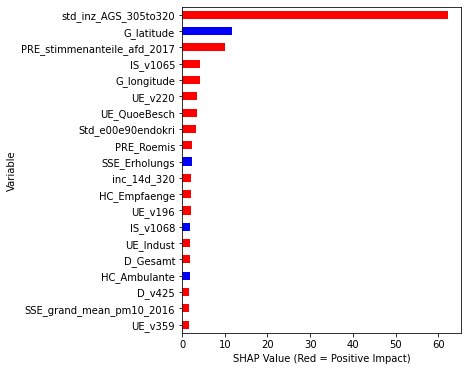

In [9]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

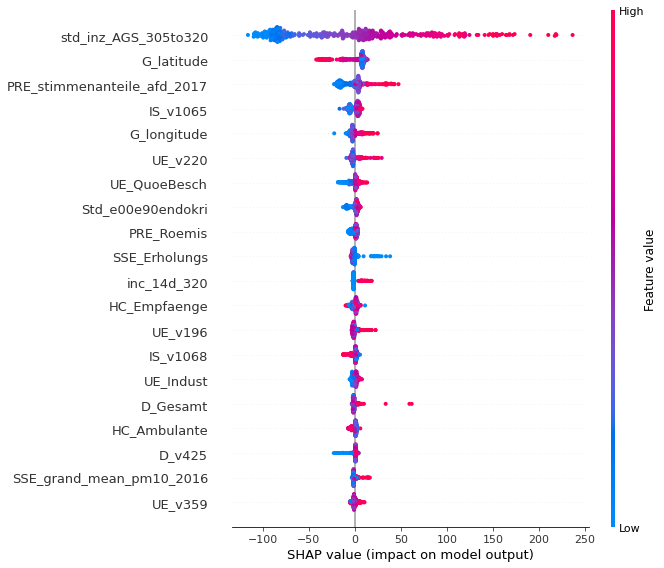

In [10]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [11]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [12]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9964492728963575


In [13]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  8.584684863522071


# Compare top 10 features of both Models

In [14]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_305to320', 'G_latitude', 'PRE_stimmenanteile_afd_2017', 'IS_v1065', 'G_longitude', 'UE_v220', 'UE_QuoeBesch', 'Std_e00e90endokri', 'PRE_Roemis', 'SSE_Erholungs'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_305to320', 'PRE_stimmenanteile_afd_2017', 'G_latitude', 'G_longitude', 'Std_e00e90endokri', 'UE_v220', 'UE_QuoeBesch', 'IS_v1065', 'UE_Indust', 'SSE_grand_mean_pm10_2016']


In [15]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_305to320
G_latitude
PRE_stimmenanteile_afd_2017
IS_v1065
G_longitude
UE_v220
UE_QuoeBesch
Std_e00e90endokri


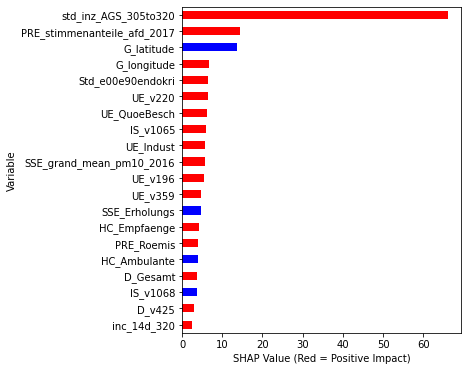

In [16]:
ABS_SHAP(shap_values_cb_20,X[top20feature]) 

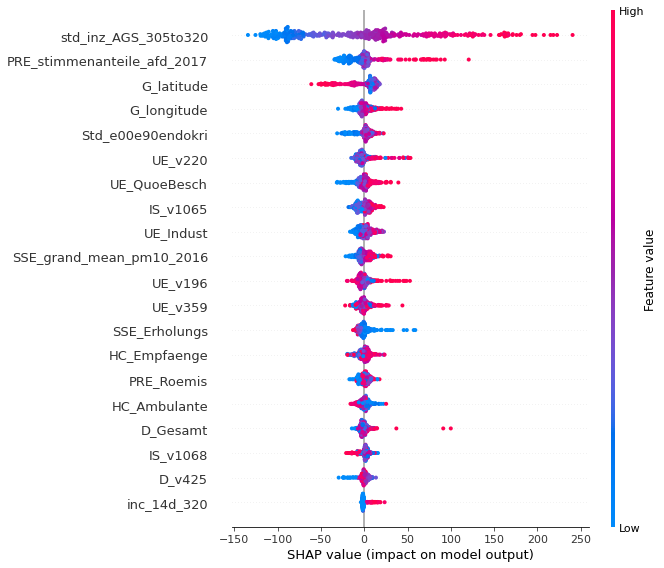

In [17]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [18]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [19]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9980347281408036
Mean R2 of linReg_modesl with top20 features:  0.6666345743476899
Mean RMSE of CatBoost_models on test sets with top20 features:  81.38888571369044
Mean R2 of CatBoost_models on test sets with top20 features: 0.6582917604017637


# descriptives of top20 features

In [20]:
X[top20feature].describe()

,std_inz_AGS_305to320,G_latitude,PRE_stimmenanteile_afd_2017,IS_v1065,G_longitude,UE_v220,UE_QuoeBesch,Std_e00e90endokri,PRE_Roemis,SSE_Erholungs,inc_14d_320,HC_Empfaenge,UE_v196,IS_v1068,UE_Indust,D_Gesamt,HC_Ambulante,D_v425,SSE_grand_mean_pm10_2016,UE_v359
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,294.754181,50.615307,13.388280,21.925186,9.866997,34.556614,49.557602,64.049629,32.242802,70.509460,201.515823,50.857349,66.924667,1050.970093,18.253864,5.103244,23.816227,5.230676,14.254108,68.926453
std,132.152008,1.740311,5.329521,15.378860,2.026269,13.284161,5.944391,15.094089,24.361443,56.734703,400.715698,6.518342,6.630356,542.184448,8.723560,4.276378,5.234064,9.954544,2.204698,11.196053
min,51.452923,47.500000,4.900000,0.000000,6.083333,4.600000,29.600000,0.000000,1.700000,14.000000,0.000000,28.600000,44.299999,13.000000,0.000000,-14.000000,0.000000,-32.299999,8.902052,27.500000
25%,187.580597,49.283333,9.800000,13.000000,8.216666,26.100000,45.700001,54.863358,7.900000,39.700001,0.000000,46.400002,62.700001,582.000000,12.700000,2.500000,20.100000,-0.700000,12.644478,62.099998
50%,295.148651,50.549999,12.000000,21.000000,9.766666,32.000000,49.900002,63.261333,29.100000,52.799999,0.000000,51.099998,67.599998,1056.000000,17.200001,5.100000,23.799999,5.100000,14.194455,70.000000
75%,375.239899,51.849998,15.300000,32.000000,11.416667,41.400002,53.599998,72.358131,52.299999,76.699997,0.000000,55.599998,71.300003,1458.000000,22.700001,7.500000,27.200001,11.300000,15.811378,76.699997
max,734.390442,54.783333,35.500000,79.000000,14.983334,101.000000,66.400002,112.477448,87.800003,384.600006,1302.830811,66.699997,81.599998,2782.000000,91.800003,21.299999,44.400002,35.700001,21.132412,95.099998


In [21]:
pd.DataFrame(Y).describe()

,std_inz_AGS_320to335
count,401.000000
mean,299.439178
std,144.247375
min,20.302881
25%,203.504822
50%,286.181732
75%,371.910645
max,968.592468


In [22]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives1.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 1')